In [8]:
import pandas as pd
from keras.layers import *
from keras.regularizers import *
from keras.models import *
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

In [20]:
beers = pd.read_csv('beer_reviews.csv.bz2')
idx_reviewer = beers.groupby('review_profilename').size().reset_index()
idx_reviewer.shape

(33387, 2)

In [10]:
user2idx = dict(zip(idx_reviewer.review_profilename, idx_reviewer.index.values))
idx_beers = beers.groupby('beer_name').size().reset_index()
idx_beers.shape

(56857, 2)

In [11]:
beer2idx = dict(zip(idx_beers.beer_name, idx_beers.index.values))
idx2beer = dict(zip(idx_beers.index.values,idx_beers.beer_name))

beers['beer_idx'] = [beer2idx.get(b) for b in beers.beer_name]
beers['user_idx'] = [user2idx.get(u) for u in beers.review_profilename]

beers.loc[:, ['user_idx', 'beer_idx', 'review_overall']].as_matrix()

n_users = len(user2idx) 
n_beers = len(beer2idx) 

In [4]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, 20, input_length=1,embeddings_regularizer=l2(1e-5))(user_in)

beer_in = Input(shape=(1,), dtype='int64', name='beer_in')
b = Embedding(n_beers, 20, input_length=1,embeddings_regularizer=l2(1e-5))(beer_in)

x = Dot(axes=2)([u,b])
x = Flatten()(x)

model = Model([user_in, beer_in], x)

model.compile('Adam',loss='mse')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
beer_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        667740      user_in[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 20)        1137140     beer_in[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

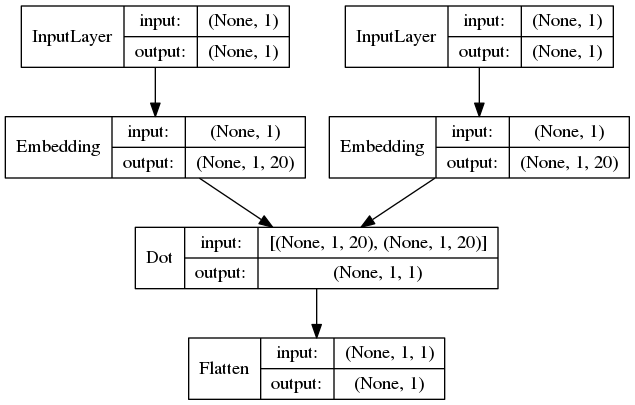

In [19]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

In [6]:
data_set_mat = beers.loc[:, ['user_idx', 'beer_idx', 'review_overall']].as_matrix()

history = model.fit(x=[data_set_mat[:,0], data_set_mat[:,1]], y=data_set_mat[:,2], 
                    batch_size=64, epochs=10, validation_split=0.1, verbose=2)

Train on 1427952 samples, validate on 158662 samples
Epoch 1/10
 - 66s - loss: 4.6260 - val_loss: 15.3516
Epoch 2/10
 - 60s - loss: 2.5994 - val_loss: 15.3719
Epoch 3/10
 - 60s - loss: 2.5567 - val_loss: 15.3726
Epoch 4/10
 - 60s - loss: 2.5165 - val_loss: 15.3920
Epoch 5/10
 - 60s - loss: 2.4975 - val_loss: 15.3773
Epoch 6/10
 - 60s - loss: 2.4882 - val_loss: 15.3994
Epoch 7/10
 - 60s - loss: 2.4841 - val_loss: 15.3882
Epoch 8/10
 - 60s - loss: 2.4778 - val_loss: 15.3692
Epoch 9/10
 - 60s - loss: 2.4743 - val_loss: 15.3741
Epoch 10/10
 - 60s - loss: 2.4737 - val_loss: 15.3721


In [12]:
beer_dist = euclidean_distances(X=model.layers[3].get_weights()[0])

#[k for k, v in beer2idx.items() if k.startswith('Guinness')]

In [13]:
def get_beer_recomm(beer_nm, beer_dist, idx2beer, topN=10):
    q_b_idx = beer2idx[beer_nm]
    beer_dists = beer_dist[q_b_idx]
    orders = np.argsort(beer_dists)
    return(zip(beer_dists[orders[:topN]], [idx2beer[i] for i in orders[:topN]]))
    
    

In [15]:
rec = get_beer_recomm('Indica India Pale Ale',beer_dist, idx2beer, topN=10)
tuple(rec)

((0.0, 'Indica India Pale Ale'),
 (0.18242778, 'Bengali Tiger'),
 (0.18408915, 'Tröegs Dead Reckoning Porter'),
 (0.20235237, 'ACME California IPA'),
 (0.20946412, 'Odell 90 Shilling Ale'),
 (0.21144439, 'Kentucky Bourbon Barrel Ale'),
 (0.21554285, 'Juniper Pale Ale'),
 (0.22981298, 'Bully! Porter'),
 (0.23215295, 'Full Sail Wassail'),
 (0.23331977, 'Terrapin Hopsecutioner'))

In [16]:
rec = get_beer_recomm('Samuel Adams Boston Lager',beer_dist, idx2beer, topN=10)
tuple(rec)

((0.0, 'Samuel Adams Boston Lager'),
 (0.44417816, 'Anchor Steam Beer'),
 (0.47144812, 'Samuel Adams Octoberfest'),
 (0.49871373, 'Hoegaarden Original White Ale'),
 (0.50791579, 'Samuel Adams Noble Pils'),
 (0.53693092, "Bell's Oberon Ale"),
 (0.54775667, 'Samuel Adams Winter Lager'),
 (0.58550274, 'Guinness Extra Stout (Original)'),
 (0.60181528, 'Franziskaner Hefe-Weisse'),
 (0.61106598, "Samuel Smith's Nut Brown Ale"))